In [6]:
# Install TabPFN
!pip install tabpfn --upgrade --quiet
!pip install tabpfn-extensions --upgrade --quiet

In [7]:
# Author: Aaron Isom
# Kaggle Playground-Series-S5e8 - Binary Classification with a Bank Dataset

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score,  train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tabpfn_extensions import TabPFNClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

# Load data
train = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
original = pd.read_csv('/kaggle/input/bank-marketing-dataset-full/bank-full.csv', delimiter=";")
submission = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')

original['y'] = original['y'].map({'yes': 1, 'no': 0})

train = pd.concat([train, original], axis=0, ignore_index=True)

# Features for training (drop id and target)
X = train.drop(['id', 'y'], axis=1)
y = train['y']

# Features for test set (drop only id)
X_test = test.drop(['id'], axis=1)

# Encode object and category columns to ensure unique values are mapped
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    le.fit(list(X[col].astype(str)) + list(X_test[col].astype(str)))
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


Class Distribution:
 y
0    699434
1     95777
Name: count, dtype: int64

Imbalance Ratio: 0.1369


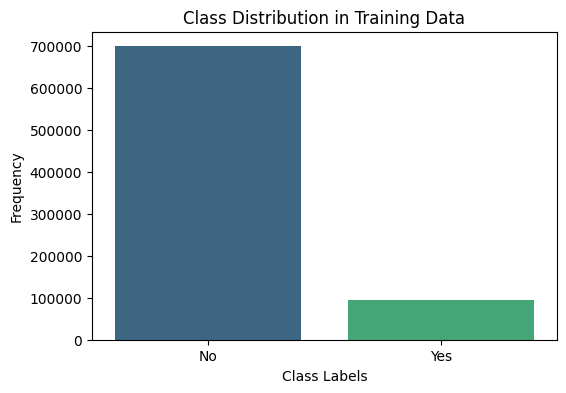

In [8]:
# Check class counts
class_counts = y.value_counts()
print("\nClass Distribution:\n", class_counts)

# Compute imbalance ratio
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"\nImbalance Ratio: {imbalance_ratio:.4f}")  # Closer to 0 means more imbalance

# Plot imbalances
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Data")
plt.xticks([0, 1], labels=["No", "Yes"])  # Adjust labels if needed
plt.show()

In [ ]:
# Subsample for TabPFN
X_small = X.sample(n=25000, random_state=42)
y_small = y.loc[X_small.index]

tabpfn_subsample_clf = TabPFNClassifier(
    ignore_pretraining_limits=True,
    n_estimators=5,
    inference_config={"SUBSAMPLE_SAMPLES": 1000}
)

scores = cross_val_score(tabpfn_subsample_clf, X_small, y_small, cv=3, scoring='roc_auc')
print("ROC AUC:", scores.mean())

In [ ]:
# Final submission
preds = tabpfn_subsample_clf.predict_proba(X_test)[:, 1]

submission['y'] = preds
submission.to_csv('submission.csv', index=False)
display(submission)
print('Submission file saved.')